### pitstop dataset

build a pitstop dataset across all the oval races

gap distribution analysis. 
+ comparison with normalized histgram
+ no yellow flag, pure racing stint
+ yellow flag raised, pitstop at green flag
+ yellow flag raised, pitstop at caution flag

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"

## Load Data

In [2]:
import os
os.getcwd()

'/scratch/hpda/indycar/predictor/notebook/8.PitStopAnalysis'

In [3]:
#
# parameters
#
#year = '2017'
year = '2018'
#event = 'Toronto'
#https://www.racing-reference.info/season-stats/2018/O/#
events_totalmiles=[256,500,372,268,500,310]
events_laplen = [1.022,2.5,1.5,0.894,2.5,1.25]
events = ['Phoenix','Indy500','Texas','Iowa','Pocono','Gateway']
events_id={key:idx for idx, key in enumerate(events)}
#events = ['Indy500']
#events = ['Phoenix']

In [4]:
# make indy car completed_laps dataset
# car_number, completed_laps, rank, elapsed_time, rank_diff, elapsed_time_diff 
def make_cl_data(dataset):

    # pick up data with valid rank
    rankdata = dataset.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')

    # resort by car_number, lap
    uni_ds = rankdata.sort_values(by=['car_number', 'completed_laps', 'elapsed_time'], ascending=True)    
    uni_ds = uni_ds.drop(["unique_id", "best_lap", "current_status", "track_status", "lap_status",
                      "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
                      "last_pitted_lap","start_position","laps_led"], axis=1)
    
    carnumber = set(uni_ds['car_number'])
    print('cars:', carnumber)
    print('#cars=', len(carnumber))
   
    # faster solution , uni_ds already sorted by car_number and lap
    uni_ds['rank_diff'] = uni_ds['rank'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['rank_diff'][mask] = 0
    
    uni_ds['time_diff'] = uni_ds['elapsed_time'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['time_diff'][mask] = 0
    
    df = uni_ds[['car_number','completed_laps','rank','elapsed_time','rank_diff','time_diff']]
    
    return df

def make_lapstatus_data(dataset):
    final_lap = max(dataset.completed_laps)
    total_laps = final_lap + 1

    # get records for the cars that finish the race
    completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
    completed_car_count = len(completed_car_numbers)

    print('count of completed cars:', completed_car_count)
    print('completed cars:', completed_car_numbers)
    
    #pick up one of them
    onecar = dataset[dataset['car_number']==completed_car_numbers[0]]
    onecar = onecar.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    return onecar[['completed_laps','track_status']]
    

In [5]:
def load_data(event, year):
    inputfile = '../data/final/C_'+ event +'-' + year + '-final.csv'
    outputprefix = year +'-' + event + '-'
    dataset = pd.read_csv(inputfile)
    #dataset.info(verbose=True)    
    
    final_lap = max(dataset.completed_laps)
    total_laps = final_lap + 1

    # get records for the cars that finish the race
    completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
    completed_car_count = len(completed_car_numbers)

    print('count of completed cars:', completed_car_count)
    print('completed cars:', completed_car_numbers)

    #make a copy
    alldata = dataset.copy()
    dataset = dataset[dataset['car_number'].isin(completed_car_numbers)]
    rankdata = alldata.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    
    cldata = make_cl_data(dataset)
    flagdata = make_lapstatus_data(dataset)
    acldata = make_cl_data(alldata)

    return alldata, rankdata, acldata, flagdata

### overall view of laptime scatter plots



In [6]:
def get_cardata(curcarno, ycol='time_diff'):
    car = acldata[acldata['car_number']==curcarno]
    #print(car['time_diff'].describe())
    
    cols=['completed_laps','rank','car_number','lap_status','track_status',
    'pit_stop_count','current_status','start_position']
    colid={key:idx for idx, key in enumerate(cols)}

    cardata = rankdata[rankdata['car_number'] == curcarno]

    carstatus = [[row[0], row[1],row[2],row[3],row[4],row[5],row[6],row[7]] for row in cardata[
        ['completed_laps','rank','car_number','lap_status','track_status',
        'pit_stop_count','current_status','start_position']].values]
    
    x = car['completed_laps'][1:].values
    y = car[ycol][1:].values

    pits=[]
    yellowflags=[]
    lastflag = 'x'
    for row in carstatus:
        lap = int(row[colid['completed_laps']])

        if row[colid['lap_status']]=='P':
            pits.append(lap)

        if row[colid['track_status']]=='Y':
            if lastflag != 'Y':       
                #start
                yellowflags.append(lap)
        else:
            if lastflag == 'Y':       
                #end
                yellowflags.append(lap)        
        lastflag = row[colid['track_status']]

    #pit lap
    pits = np.array(pits)
    #start, end lap
    #
    yellowflags = np.array(yellowflags)
    if (yellowflags.shape[0] % 2)==1:
        print('crash?:carno=', curcarno)
        yellowflags = []
    else:
        yellowflags = np.array(yellowflags).reshape((-1,2))    
    
    return car, x, y, pits, yellowflags

### bulid the dataset

In [7]:
def get_stagedata(TRIM=2):
    """
    input: acldata, rankdata, the whole dataset
    output: stagedata['car_number','stage','start_lap','end_lap','start_rank','end_rank','yellowflag_raised']
    """
    carlist = set(acldata['car_number'])
    data = []
    for curcarno in carlist:
        car = acldata[acldata['car_number']==curcarno]
        #print(car['time_diff'].describe())

        cols=['completed_laps','rank','car_number','lap_status','track_status',
        'pit_stop_count','current_status','start_position']
        colid={key:idx for idx, key in enumerate(cols)}

        cardata = rankdata[rankdata['car_number'] == curcarno]

        carstatus = [[row[0], row[1],row[2],row[3],row[4],row[5],row[6],row[7]] for row in cardata[
            ['completed_laps','rank','car_number','lap_status','track_status',
            'pit_stop_count','current_status','start_position']].values]

        pits=[]
        yellowflags=[]
        lastflag = 'x'
        
        stage = 0
        start_lap = 0
        pit_lap = -1
        pit_in_caution = 0
        yellowflag_raised = 0
        for row in carstatus:
            lap = int(row[colid['completed_laps']])
            
            if lap==0:
                #hex2int
                start_rank = int(row[colid['start_position']], 16)     
            
            if row[colid['track_status']]=='Y':
                yellowflag_raised = 1
                if lastflag != 'Y':       
                    #start
                    yellowflags.append(lap)
            else:
                if lastflag == 'Y':       
                    #end
                    yellowflags.append(lap)        
            lastflag = row[colid['track_status']]
            
            if row[colid['lap_status']]=='P' and row[colid['current_status']]=='Active':
                pits.append(lap)
                end_lap = lap - TRIM
                end_rank = carstatus[end_lap][colid['rank']]
                
                #pit_lap = lap  #current is pit lap
                
                #redefine pit_lap as the previous caution_lap
                #pit_lap = yellowflags[-1]
                #pit_in_caution = 1 if row[colid['track_status']]=='Y' else 0
                if row[colid['track_status']]=='Y':
                    pit_lap = yellowflags[-1]
                    pit_in_caution = 1
                else:
                    pit_lap = lap
                    pit_in_caution = 0
                
                #add one record
                #stagedata['car_number','stage','start_lap','end_lap','start_rank','end_rank','yellowflag_raised']
                data.append([curcarno,stage,start_lap, end_lap, pit_lap, pit_in_caution, 
                             start_rank, end_rank,yellowflag_raised])
                # prepare for the next
                stage += 1
                start_lap = end_lap  # end_lap + 1?
                start_rank = end_rank
                yellowflag_raised = 1 if lastflag=='Y' else 0

        #final
        end_lap = carstatus[-1][colid['completed_laps']]
        end_rank = carstatus[-1][colid['rank']]
        #add one record
        #stagedata['car_number','stage','start_lap','end_lap',pit_lap, pit_in_caution,'start_rank','end_rank']
        #data.append([curcarno,stage,start_lap, end_lap, pit_lap, pit_in_caution, start_rank, end_rank])
        
        #pit lap
        pits = np.array(pits)
        #start, end lap
        #
        yellowflags = np.array(yellowflags)
        if (yellowflags.shape[0] % 2)==1:
            print('crash?:carno=', curcarno)
            yellowflags = []
        else:
            yellowflags = np.array(yellowflags).reshape((-1,2))  
            
    data = np.array(data)
    #['car_number','stage','start_lap','end_lap',pit_lap, pit_in_caution,'start_rank','end_rank']
    df = pd.DataFrame({'car_number': data[:, 0], 'stage': data[:, 1],'start_lap': data[:, 2],
                      'end_lap': data[:, 3], 'pit_lap': data[:, 4], 'pit_in_caution': data[:, 5],
                       'start_rank': data[:, 6],'end_rank': data[:, 7],'yellowflag_raised':data[:,8]})
    return df, data

### events

In [8]:
def extract_stint_features(stagedata):
    """
    input: (alldata, rankdata, acldata, flagdata, stage, data)
    
    lap_distance    ; lap distance for this stint
    start_lap
    caution_distance
    
    eventid
    car_number
    stageid
    
    pit_in_caution; 1/0
    yellowflag_raised ; 1/0
    
    start_position  ; #
    start_rank  ;  #rank
    end_rank
    """
    #eventid = 0
    cols=['lap_distance','start_lap','caution_distance',
             'eventid','car_number','stageid',
             'pit_in_caution', 'yellowflag_raised',
             'start_position', 'start_rank', 'end_rank']
    colid={key:idx for idx, key in enumerate(cols)}
    
    datacols = ['car_number','stage','start_lap','end_lap','pit_lap', 
                'pit_in_caution', 'start_rank','end_rank','yellowflag_raised']
    datacolid={key:idx for idx, key in enumerate(datacols)}
    
    #maintain a <car,lap, (rank, stage)> index 
    idxcols = ['car_number','completed_laps','rank','stageid']
    carindex = {}
    
    stagedf = pd.DataFrame([],columns=cols)
    for event in stagedata.keys():
        
        eventid = events_id[event]
        
        alldata, rankdata, acldata, flagdata, stage, data = stagedata[event]
        carlist = set(acldata['car_number'])
        laplist = set(acldata['completed_laps'])
        totalcars = len(carlist)
        totallaps = len(laplist)

        # init the index
        #carindex[eventid] = np.array((totalcars, totallaps, 2))
        carindex[eventid] = pd.DataFrame([],columns=idxcols)
        
        records = []
        
        laphist = []
        rankhist = []
        rankchghist = []        
        #['car_number','stage','start_lap','end_lap',pit_lap, pit_in_caution, 'start_rank','end_rank']
        for row in data:
            # a new record
            rec={}
            #status, 'start_lap', start a new car
            if row[datacolid['start_lap']] == 0:
                start_position = row[datacolid['start_rank']]
                laphist = []
                rankhist = []
                rankchghist = []
            
            #target 
            rec['lap_distance'] = row[datacolid['end_lap']] - row[datacolid['start_lap']] + 1
            rec['start_lap'] = row[datacolid['start_lap']]
            rec['caution_distance'] = row[datacolid['end_lap']] - row[datacolid['pit_lap']] + 1
            
            #features
            rec['eventid'] = eventid
            rec['car_number'] = row[datacolid['car_number']]
            rec['stageid'] = row[datacolid['stage']]
            
            rec['pit_in_caution'] = row[datacolid['pit_in_caution']]
            rec['yellowflag_raised'] = row[datacolid['yellowflag_raised']]
            
            rec['start_position'] = start_position
            rec['start_rank'] = row[datacolid['start_rank']]
            rec['end_rank'] = row[datacolid['end_rank']]
            
            
            #add one record
            records.append([rec[col] for col in cols])
            
            #update for the new stage
            lapdata = rankdata[(rankdata['car_number']== rec['car_number']) & 
                               (rankdata['completed_laps']>=row[datacolid['start_lap']]) &
                               (rankdata['completed_laps']<row[datacolid['end_lap']])
                              ]
            laphist.append(lapdata)
            rankhist.extend(list(lapdata['rank']))
            rankchghist.append(row[datacolid['end_rank']] - row[datacolid['start_rank']])
            
            # add to index, go through the lapdata
            #or _lap in range(row[datacolid['start_lap']],row[datacolid['end_lap']]):
            for index, row in lapdata.iterrows():
                #carindex[eventid][rec['car_number'], row['completed_laps'], 0] = row['rank']
                #carindex[eventid][rec['car_number'], row['completed_laps'], 1 = rec['stageid']
                laprec = [rec['car_number'], row['completed_laps'], row['rank'],rec['stageid']]
                df = pd.DataFrame([laprec],columns=idxcols)
                carindex[eventid] = pd.concat([carindex[eventid], df], ignore_index=True)
            
          
        # push this event into stage dataframe
        print('event=%s, records=%d'%(event, len(records)))
        df = pd.DataFrame(records,columns=cols)
        stagedf = pd.concat([stagedf, df], ignore_index=True)
        
        #for the next new event
        #eventid += 1
        
    return stagedf, carindex

### load data

In [9]:
stagedata = {}
traindata = None
for event in events:
    #alldata, rankdata, acldata, flagdata
    stagedata[event] = load_data(event, year)
    
    alldata, rankdata, acldata, flagdata = stagedata[event]
    carlist = set(acldata['car_number'])
    laplist = set(acldata['completed_laps'])
    print('%s: carno=%d, lapnum=%d'%(event, len(carlist), len(laplist)))
    
    stage, data = get_stagedata(0)
    stagedata[event] = (alldata, rankdata, acldata, flagdata, stage, data)
    
    if traindata is None:
        traindata = data
    else:
        traindata = np.vstack((traindata, data))

('count of completed cars:', 11)
('completed cars:', array([ 1,  6, 27,  9, 28,  5, 20, 14, 15, 22, 30]))
('cars:', set([1, 5, 6, 9, 14, 15, 20, 22, 27, 28, 30]))
('#cars=', 11)
('count of completed cars:', 11)
('completed cars:', array([ 1,  6, 27,  9, 28,  5, 20, 14, 15, 22, 30]))
('cars:', set([1, 4, 5, 6, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 26, 27, 28, 30, 32, 59, 88, 98]))
('#cars=', 23)


/scratch/hpda/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/scratch/hpda/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Phoenix: carno=23, lapnum=251
('crash?:carno=', 10)
('crash?:carno=', 19)
('count of completed cars:', 18)
('completed cars:', array([12, 20,  9, 27, 28, 22, 29,  1,  6, 15, 66, 98,  4, 88, 25, 60, 64,
       23]))
('cars:', set([64, 1, 66, 4, 6, 9, 12, 98, 15, 60, 20, 22, 23, 88, 25, 27, 28, 29]))
('#cars=', 18)
('count of completed cars:', 18)
('completed cars:', array([12, 20,  9, 27, 28, 22, 29,  1,  6, 15, 66, 98,  4, 88, 25, 60, 64,
       23]))
('cars:', set([1, 3, 4, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 59, 60, 64, 66, 88, 98]))
('#cars=', 33)
Indy500: carno=33, lapnum=201
('crash?:carno=', 3)
('crash?:carno=', 24)
('crash?:carno=', 33)
('count of completed cars:', 9)
('completed cars:', array([ 9, 22, 27,  5, 28, 15, 30, 18, 10]))
('cars:', set([5, 9, 10, 15, 18, 22, 27, 28, 30]))
('#cars=', 9)
('count of completed cars:', 9)
('completed cars:', array([ 9, 22, 27,  5, 28, 15, 30, 18, 10]))
('cars:', set([1, 3, 4, 5, 6, 7,

In [10]:
stintdf, carindex = extract_stint_features(stagedata)

event=Iowa, records=83
event=Phoenix, records=89
event=Indy500, records=189
event=Pocono, records=104
event=Gateway, records=83
event=Texas, records=95


In [11]:
#stagedf0.reset_index(inplace=True)
#stagedf = update_neighbor(stagedf0, carindex) 

In [12]:
#stintdf = stintdf.drop(columns=['start_lap'])

In [13]:
stintdf.to_csv('stint-v2-%s.csv'%year)

In [14]:
stintdf.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 11 columns):
lap_distance         643 non-null object
start_lap            643 non-null object
caution_distance     643 non-null object
eventid              643 non-null object
car_number           643 non-null object
stageid              643 non-null object
pit_in_caution       643 non-null object
yellowflag_raised    643 non-null object
start_position       643 non-null object
start_rank           643 non-null object
end_rank             643 non-null object
dtypes: object(11)
memory usage: 55.3+ KB


In [15]:
stintdf.head(10)

,lap_distance,start_lap,caution_distance,eventid,car_number,stageid,pit_in_caution,yellowflag_raised,start_position,start_rank,end_rank
0,81,0,1,3,1,0,0,0,2,2,1
1,63,80,4,3,1,1,1,1,2,1,1
2,83,142,1,3,1,2,0,1,2,1,3
3,74,224,4,3,1,3,1,1,2,3,2
4,77,0,1,3,5,0,0,0,11,11,6
5,67,76,5,3,5,1,1,1,11,6,4
6,82,142,1,3,5,2,0,1,11,4,7
7,80,0,1,3,6,0,0,0,7,7,3
8,68,79,10,3,6,1,1,1,7,3,6
9,79,146,1,3,6,2,0,1,7,6,4


### pitstop analysis

In [26]:
def get_distance_data(data, event=[],car_number=[]):
    """
    data ; stintdf
    events_laplen = [1.022,2.5,1.5,0.894,2.5,1.25]
    
    return:
    normal_stint   ; stint without yellow flags
    yellow_stint   ; yellow flag raised and stop in normal lap
    caution_stint  ; yellow flag raised and stop in caution lap
    
    """
    if car_number:
        data = data[data['car_number'].isin(car_number)]
    if event:
        eventid = [events_id[x] for x in event]
        data = data[data['eventid'].isin(eventid)]
        
    car = data
    
    normal_stint = car[(car['pit_in_caution']==0) & (car['yellowflag_raised']==0)][['eventid','lap_distance']].to_numpy()
    normal_laplen = [events_laplen[x[0]]*x[1] for x in normal_stint]
    
    yellow_stint = car[(car['pit_in_caution']==0) & (car['yellowflag_raised']==1)][['eventid','lap_distance']].to_numpy()
    yellow_laplen = [events_laplen[x[0]]*x[1] for x in yellow_stint]
    
    # distance to the previous pitstop lap
    caution_stint = car[car['pit_in_caution']==1][['eventid','lap_distance']].to_numpy()
    caution_laplen = [events_laplen[x[0]]*x[1] for x in caution_stint]
    
    # distance to the first caution lap
    caution_stint = car[car['pit_in_caution']==1][['eventid','caution_distance']].to_numpy()
    caution_laplen2 = [events_laplen[x[0]]*x[1] for x in caution_stint]
  
    
    #plot it
    return normal_laplen, yellow_laplen, caution_laplen, caution_laplen2


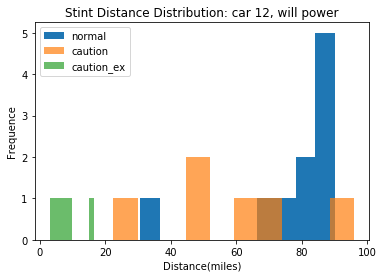

In [34]:
# car 12, will power
set(rankdata[rankdata['car_number']==12]['last_pitted_lap'])
nlap, ylap, clap, clap2 = get_distance_data(stintdf, car_number=[12])
plt.hist(nlap,label='normal')
plt.hist(clap, alpha=0.7,label='caution')
plt.hist(clap2, alpha=0.7,label='caution_ex')
plt.xlabel('Distance(miles)')
plt.ylabel('Frequence')
plt.title('Stint Distance Distribution: car 12, will power')
plt.legend(prop={'size': 10})

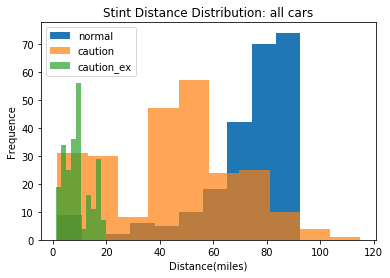

In [35]:
#get all data
carno_set = set(stintdf['car_number'].values)
normal_dist,yellow_dist, caution_dist,caution_dist2  = get_distance_data(stintdf, car_number=carno_set)    
plt.hist(normal_dist,label='normal')
plt.hist(caution_dist,alpha=0.7,label='caution')
plt.hist(caution_dist2,alpha=0.7,label='caution_ex')
plt.xlabel('Distance(miles)')
plt.ylabel('Frequence')
plt.title('Stint Distance Distribution: all cars')
plt.legend(prop={'size': 10})

(array([19., 34., 25., 36., 56.,  4., 16., 11., 29.,  7.]),
 array([ 1.25 ,  3.125,  5.   ,  6.875,  8.75 , 10.625, 12.5  , 14.375,
        16.25 , 18.125, 20.   ]),
 <a list of 10 Patch objects>)

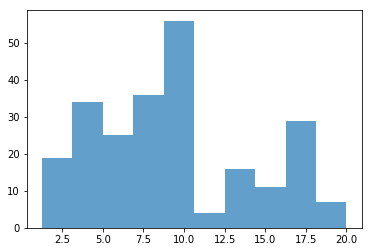

In [36]:
plt.hist(caution_dist2,alpha=0.7)

(array([ 2.,  0., 22.,  0., 28.,  5.,  0.,  5.,  7.,  6.]),
 array([ 2.5 ,  4.25,  6.  ,  7.75,  9.5 , 11.25, 13.  , 14.75, 16.5 ,
        18.25, 20.  ]),
 <a list of 10 Patch objects>)

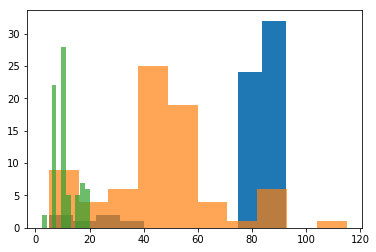

In [37]:
#get all data for one event
carno_set = set(stintdf['car_number'].values)
event_set = ['Indy500']
normal_dist,yellow_dist,caution_dist,caution_dist2 = get_distance_data(stintdf, event=event_set, car_number=carno_set) 
plt.hist(normal_dist)
plt.hist(caution_dist,alpha=0.7)
plt.hist(caution_dist2,alpha=0.7)

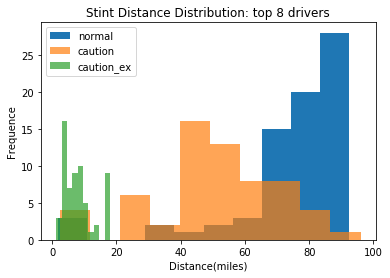

In [38]:
# the top drivers
#https://www.racing-reference.info/dquery2.jsp
top_cars=[9,1,12,27,28,18,5,30]
normal_dist,yellow_dist,caution_dist,caution_dist2 = get_distance_data(stintdf, car_number=top_cars)  
plt.hist(normal_dist,label='normal')
plt.hist(caution_dist,alpha=0.7,label='caution')
plt.hist(caution_dist2,alpha=0.7,label='caution_ex')
plt.xlabel('Distance(miles)')
plt.ylabel('Frequence')
plt.title('Stint Distance Distribution: top 8 drivers')
plt.legend(prop={'size': 10})

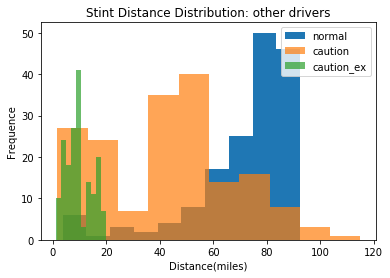

In [39]:
other_cars=set(carno_set).difference(set(top_cars))
normal_dist,yellow_dist,caution_dist,caution_dist2 = get_distance_data(stintdf, car_number=other_cars)  
plt.hist(normal_dist,label='normal')
plt.hist(caution_dist,alpha=0.7,label='caution')
plt.hist(caution_dist2,alpha=0.7,label='caution_ex')
plt.xlabel('Distance(miles)')
plt.ylabel('Frequence')
plt.title('Stint Distance Distribution: other drivers')
plt.legend(prop={'size': 10})

(array([10., 24., 18., 27., 41.,  3., 14., 11., 20.,  7.]),
 array([ 1.25 ,  3.125,  5.   ,  6.875,  8.75 , 10.625, 12.5  , 14.375,
        16.25 , 18.125, 20.   ]),
 <a list of 10 Patch objects>)

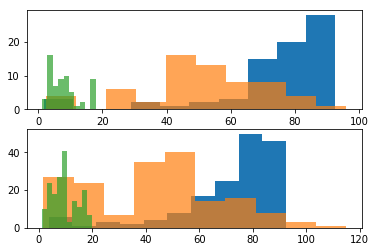

In [41]:
# subplot comparison
fig, axs = plt.subplots(2, 1)
#get all data
carno_set = set(stintdf['car_number'].values)
normal_dist,yellow_dist,caution_dist,caution_dist2 = get_distance_data(stintdf, car_number=carno_set)    
#axs[0].hist(normal_dist)
#axs[0].hist(caution_dist,alpha=0.7)
# the top drivers
#https://www.racing-reference.info/dquery2.jsp
top_cars=[9,1,12,27,28,18,5,30]
normal_dist,yellow_dist,caution_dist,caution_dist2 = get_distance_data(stintdf, car_number=top_cars)  
axs[0].hist(normal_dist)
axs[0].hist(caution_dist,alpha=0.7)
axs[0].hist(caution_dist2,alpha=0.7)
# the other cars
other_cars=set(carno_set).difference(set(top_cars))
normal_dist,yellow_dist,caution_dist,caution_dist2 = get_distance_data(stintdf, car_number=other_cars)  
axs[1].hist(normal_dist)
axs[1].hist(caution_dist,alpha=0.7)
axs[1].hist(caution_dist2,alpha=0.7)

/scratch/hpda/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/scratch/hpda/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  app.launch_new_instance()
/scratch/hpda/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


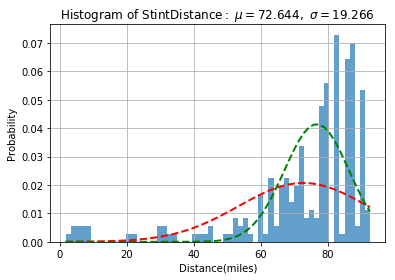

In [42]:
# fit the data with normal distribution
from scipy.stats import norm
import matplotlib.mlab as mlab

#get all data
carno_set = set(stintdf['car_number'].values)
normal_dist,yellow_dist,caution_dist,_ = get_distance_data(stintdf, car_number=carno_set)    

# best fit of data
(mu, sigma) = norm.fit(normal_dist)

# the histogram of the data
n, bins, patches = plt.hist(normal_dist, 60,normed=1, alpha=0.7)

# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)


y = mlab.normpdf( bins, mu+4, sigma/2)
l = plt.plot(bins, y, 'g--', linewidth=2)


#plot
plt.xlabel('Distance(miles)')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ StintDistance:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)


### normalized comparison

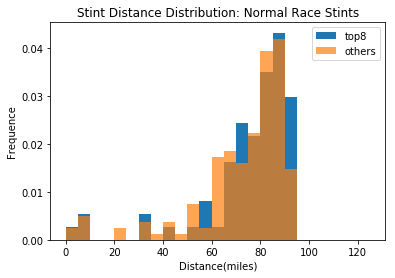

In [31]:
#normalize the comparison
bins = range(0,130, 5)
top_cars=[9,1,12,27,28,18,5,30]
normal_dist,yellow_dist,caution_dist,caution_dist2 = get_distance_data(stintdf, car_number=top_cars)  
n, bins, patches = plt.hist(normal_dist,bins=bins, label='top8', density=True,histtype='stepfilled')

other_cars=set(carno_set).difference(set(top_cars))
normal_dist,yellow_dist,caution_dist,caution_dist2 = get_distance_data(stintdf, car_number=other_cars)  
n2, bins2, patches2 = plt.hist(normal_dist,bins=bins,label='others', alpha=0.7,density=True,histtype='stepfilled')
plt.xlabel('Distance(miles)')
plt.ylabel('Frequence')
plt.title('Stint Distance Distribution: Normal Race Stints')
plt.legend(prop={'size': 10})

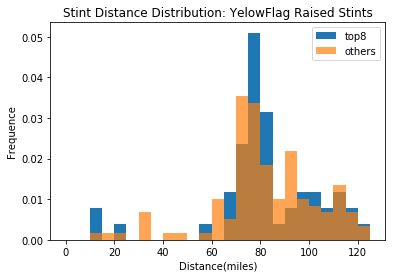

In [32]:
#normalize the comparison
bins = range(0,130, 5)
top_cars=[9,1,12,27,28,18,5,30]
normal_dist,yellow_dist,caution_dist,caution_dist2 = get_distance_data(stintdf, car_number=top_cars)  
n, bins, patches = plt.hist(yellow_dist,bins=bins, label='top8', density=True,histtype='stepfilled')


other_cars=set(carno_set).difference(set(top_cars))
normal_dist,yellow_dist,caution_dist,caution_dist2 = get_distance_data(stintdf, car_number=other_cars)  
n2, bins2, patches2 = plt.hist(yellow_dist,bins=bins,label='others', alpha=0.7,density=True,histtype='stepfilled')
plt.xlabel('Distance(miles)')
plt.ylabel('Frequence')
plt.title('Stint Distance Distribution: YelowFlag Raised Stints')
plt.legend(prop={'size': 10})

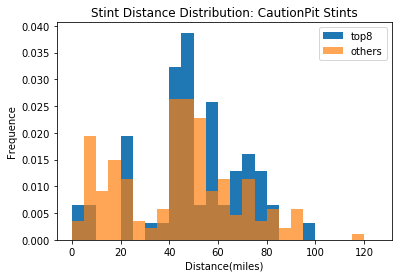

In [33]:
#normalize the comparison
bins = range(0,130, 5)
top_cars=[9,1,12,27,28,18,5,30]
normal_dist,yellow_dist,caution_dist,caution_dist2 = get_distance_data(stintdf, car_number=top_cars)  
n, bins, patches = plt.hist(caution_dist,bins=bins, label='top8', density=True,histtype='stepfilled')

other_cars=set(carno_set).difference(set(top_cars))
normal_dist,yellow_dist,caution_dist,caution_dist2 = get_distance_data(stintdf, car_number=other_cars)  
n2, bins2, patches2 = plt.hist(caution_dist,bins=bins,label='others', alpha=0.7,density=True,histtype='stepfilled')
plt.xlabel('Distance(miles)')
plt.ylabel('Frequence')
plt.title('Stint Distance Distribution: CautionPit Stints')
plt.legend(prop={'size': 10})

### conclusion

normal_stints seem to be a single side exponential distribution or beta.

drivers prefer to drive as far as they can